In [1]:
%matplotlib inline 

from __future__ import division

import sys
if '../' not in sys.path: sys.path.append("../")

import numpy as np
import amnet
import cvxpy

from numpy.random import seed, randn
import matplotlib.pyplot as plt

import z3

# set up global z3 parameters
# parameters from https://stackoverflow.com/a/12516269
z3.set_param('auto_config', False)
z3.set_param('smt.case_split', 5)
z3.set_param('smt.relevancy', 2)

In [2]:
# Replicate BV Fig 8.10 using CVXPY
# data generation
n = 2
N = 30
M = 30
seed(0)
Y = np.vstack((
    np.hstack((1.5 + 0.9*randn(1, int(0.6*N)), 1.5 + 0.7*randn(1, int(0.4*N)))),
    np.hstack((2*(randn(1, int(0.6*N)) + 1), 2*(randn(1, int(0.4*N)) - 1)))
))
X = np.vstack((
    np.hstack((-1.5 + 0.9*randn(1,int(0.6*M)),  -1.5 + 0.7*randn(1, int(0.4*M)))),
    np.hstack((2*(randn(1, int(0.6*M)) - 1), 2*(randn(1, int(0.4*M)) + 1))),
))
T = np.array([[-1, 1], [1, 1]])
Y = np.dot(T, Y)
X = np.dot(T, Y)

In [3]:
# solution via CVXPY
a = cvxpy.Variable(n)
b = cvxpy.Variable(1)
u = cvxpy.Variable(N)
v = cvxpy.Variable(M)
obj = cvxpy.Minimize(sum(u) + sum(v))
cons = [X.T * a - b >= 1 - u,
        Y.T * a - b <= -(1 - v),
        u >= 0,
        v >= 0]
prob = cvxpy.Problem(obj, cons)

result = prob.solve()
print result

12.5872977541


(-10, 10)

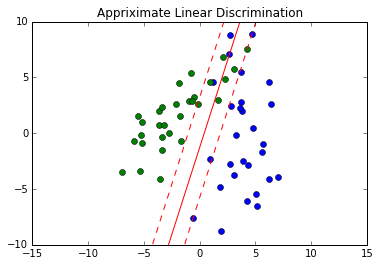

In [4]:
# graph CVXPY solution
t_min = min(np.hstack((X[0,:], Y[0,:])))
t_max = max(np.hstack((X[0,:], Y[0,:])))
tt = np.linspace(t_min-1, t_max+1, 100)
p = np.ravel(-a.value[0]/a.value[1]*tt + b.value/a.value[1])
p1 = np.ravel(-a.value[0]*tt/a.value[1] + (b.value+1)/a.value[1])
p2 = np.ravel(-a.value[0]*tt/a.value[1] + (b.value-1)/a.value[1])
plt.plot(X[0,:], X[1,:], 'o', Y[0,:], Y[1,:], 'o')
plt.plot(tt, p, '-r', tt, p1, '--r', tt, p2, '--r')
plt.title('Appriximate Linear Discrimination')
plt.axis('equal')
plt.xlim(-10, 10)
plt.ylim(-10, 10)

In [5]:
# solution via AMNET
x = amnet.Variable(n + 1 + N + M, name='x')
a = x[0:n]
b = x[n:n+1]
u = x[n+1:n+1+N]
v = x[n+1+N:n+1+N+M]
Em = np.ones((M,1))
En = np.ones((N,1))
assert len(a) == n and len(b) == 1 and len(u) == N and len(v) == M

obj = amnet.opt.Minimize(amnet.atoms.add_all(u) + amnet.atoms.add_all(v))
cons = [X.T * a - Em * b >= 1 - u,
        Y.T * a - En * b <= -(1 - v),
        u >= 0,
        v >= 0]
prob = amnet.opt.Problem(obj, cons)

result = prob.solve()


itr | lo          | hi          | gam         | res   | obj         | feas        
  1 | -1.0486e+06 |  1.0486e+06 |           0 | unsat | None        | False 
  2 |           0 |  1.0486e+06 |  5.2429e+05 | sat   |          60 | True 
  3 |           0 |  5.2429e+05 |  2.6214e+05 | sat   |          60 | True 
  4 |           0 |  2.6214e+05 |  1.3107e+05 | sat   |          60 | True 
  5 |           0 |  1.3107e+05 |       65536 | sat   |          60 | True 
  6 |           0 |       65536 |       32768 | sat   |          60 | True 
  7 |           0 |       32768 |       16384 | sat   |          60 | True 
  8 |           0 |       16384 |        8192 | sat   |          60 | True 
  9 |           0 |        8192 |        4096 | sat   |          60 | True 
 10 |           0 |        4096 |        2048 | sat   |          60 | True 
 11 |           0 |        2048 |        1024 | sat   |          60 | True 
 12 |           0 |        1024 |         512 | sat   |          60 | True 
 13

(-10, 10)

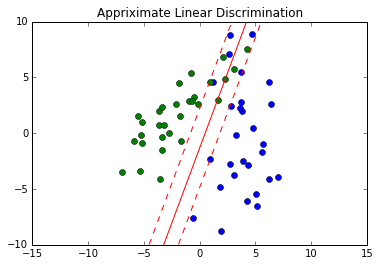

In [6]:
# graph AMNET solution
t_min = min(np.hstack((X[0,:], Y[0,:])))
t_max = max(np.hstack((X[0,:], Y[0,:])))
tt = np.linspace(t_min-1, t_max+1, 100)
av = a.eval(result.value)
bv = b.eval(result.value)
p = -av[0]/av[1]*tt + bv/av[1]
p1 = -av[0]*tt/av[1] + (bv+1)/av[1]
p2 = -av[0]*tt/av[1] + (bv-1)/av[1]
plt.plot(X[0,:], X[1,:], 'o', Y[0,:], Y[1,:], 'o')
plt.plot(tt, p, '-r', tt, p1, '--r', tt, p2, '--r')
plt.title('Appriximate Linear Discrimination')
plt.axis('equal')
plt.xlim(-10, 10)
plt.ylim(-10, 10)